# Reading a raster file and pre-processing

In [34]:
import os
import glob
import numpy as np
import rasterio
import matplotlib.pyplot as plt

In [4]:
# Landsat bands 2,3,4,5 corresponding to Blue, Green, Red, NIR.
landsat_bands = ['Band2','Band3','Band4','Band5']
image_names = {'Band2': 'LC08_L1TP_042034_20170616_20170629_01_T1_B2.TIF',
               'Band3': 'LC08_L1TP_042034_20170616_20170629_01_T1_B3.TIF',
               'Band4': 'LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF',
               'Band5': 'LC08_L1TP_042034_20170616_20170629_01_T1_B5.TIF'} 
GCloud_URL = 'https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/'

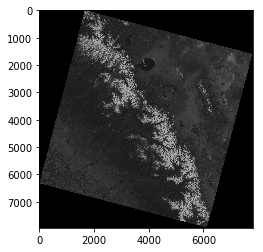

In [21]:
def read_image(input):
#     print('Reading Landsat Image from Google Cloud:')
    filepath = os.path.join(GCloud_URL,input)
    meta = []
    with rasterio.open(filepath) as src:
        meta = src.meta
        array = src.read(1)
        plt.imshow(array.squeeze(),cmap='gray')
        plt.show()
#         return array
#     with rasterio.open(output, 'w', **meta) as dst_dataset:
#         # Write data to the destination dataset.
#         dst_dataset.write(array.astype(rasterio.uint16), 1)
read_image(image_names['Band2'])

In [ ]:
def write_image(input_bands, output):
    with rasterio.open(output , 'w', **meta) as dst:
        for band, band_name in enumerate(input_bands, start=1):
            print (os.path.join(GCloud_URL, image_names[band_name]))
            with rasterio.open(os.path.join(GCloud_URL, image_names[band_name])) as src:
                dst.write_band(band, src.read(1))

In [ ]:
true_colorBC = ['Band4','Band3','Band2']
false_colorBC = ['Band5','Band4','Band3']
meta = rasterio.open(os.path.join(GCloud_URL,image_names['Band2'])).meta.copy()
meta.update (count = 3 ) # modifying meta for three bands image rather than single
write_image(true_colorBC, 'TrueColorImage.tif')
write_image(false_colorBC, 'FalseColorImage.tif')

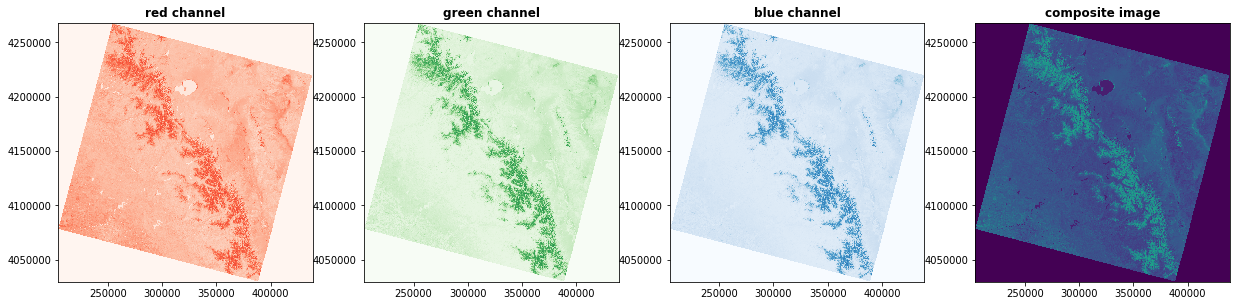

In [111]:
from rasterio.plot import show
test_image = rasterio.open('FalseColorImage.tif')
image_rasterio = test_image.read()
fig, (axr, axg, axb, ax) = plt.subplots(1,4, figsize=(21,7))
show((test_image, 1), ax=axr, cmap='Reds', title='red channel')
show((test_image, 2), ax=axg, cmap='Greens', title='green channel')
show((test_image, 3), ax=axb, cmap='Blues', title='blue channel')
show(test_image, ax=ax, cmap='viridis', title='composite image')
plt.show()

Text(0, 0.5, 'Row #')

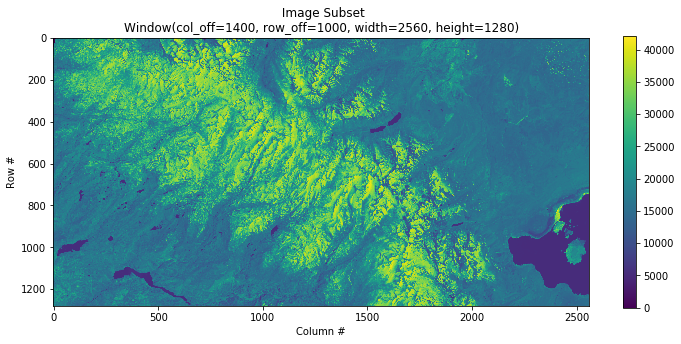

In [112]:
offset_height = 1400
offset_width = 1000
target_height = 1280
target_width = 2560
window = rasterio.windows.Window(offset_height, offset_width, target_width, target_height)

b_s, g_s, r_s = (test_image.read(k,  window=window) for k in (1, 2, 3))

plt.imshow(b_s)
plt.colorbar(shrink =0.5)
plt.title(f' Image Subset\n{window}')
plt.xlabel('Column #')
plt.ylabel('Row #')

In [113]:
meta = test_image.meta.copy()
meta.update(driver='PNG')
meta.update(width=target_width)
meta.update(height = target_height)
with rasterio.open( 'subset_image.png', 'w', **meta) as dst:
    for i, arr in [(1, b_s), (2, g_s), (3, r_s)]:
        dst.write(arr, indexes=i)



# Image processing using tensor flow and Keras functions

In [114]:
import urllib

import tensorflow as tf
import PIL.Image


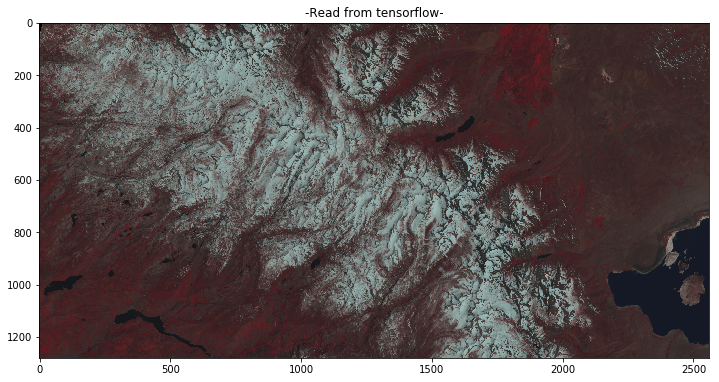

In [115]:
image_string=tf.io.read_file('subset_image.png')
image=tf.image.decode_png(image_string,channels=3)
plt.imshow(image)
plt.title('-Read from tensorflow-')
plt.show()

In [116]:
def visualizer(original, modified):
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)

    plt.subplot(1,2,2)
    plt.title('Modified image')
    plt.imshow(modified)

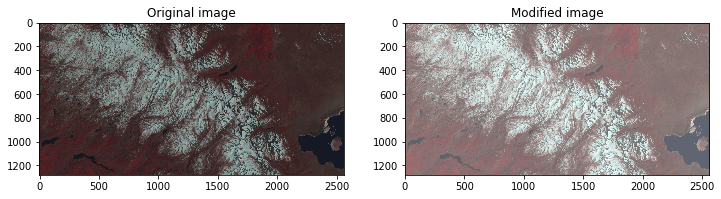

In [117]:
bright_im = tf.image.adjust_brightness(image, 0.3)
visualizer(image, bright_im)

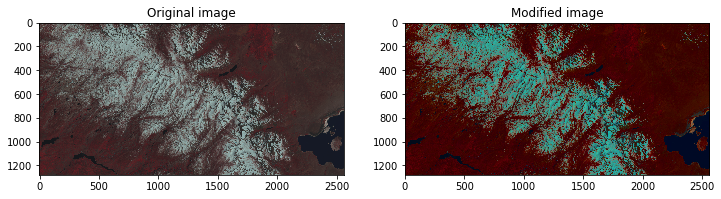

In [118]:
saturated_im = tf.image.adjust_saturation(image, 5)
visualizer(image, saturated_im)

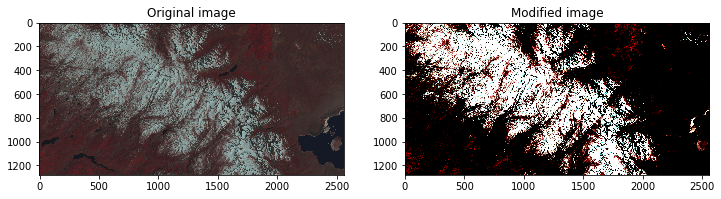

In [148]:
standardized = tf.image.per_image_standardization(image)
visualizer(image,standardized )

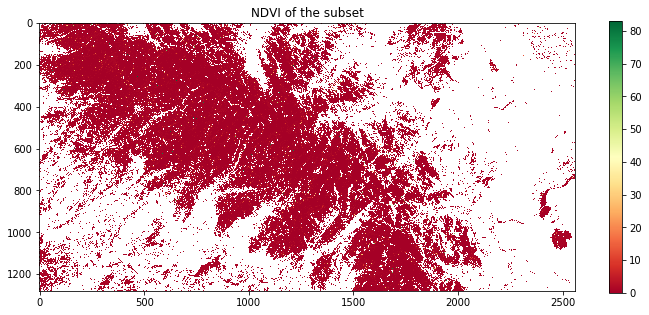

In [152]:
NDVI = ((standardized[:,:,0]-standardized[:,:,1])/(standardized[:,:,0]+standardized[:,:,1]))
plt.title("NDVI of the subset")
plt.imshow(NDVI,cmap='RdYlGn')
plt.colorbar(shrink =0.5)
plt.show()

In [154]:
from tensorflow.keras.preprocessing import image as tf_image

transformed = tf_image.apply_affine_transform(image,tx=10,ty=10 )
visualizer(image, transformed)

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'transpose'